In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

data, target = mnist["data"], mnist["target"]

print(data.shape)

data, target

(70000, 784)


c:\users\user\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
c:\users\user\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([0., 0., 0., ..., 9., 9., 9.]))

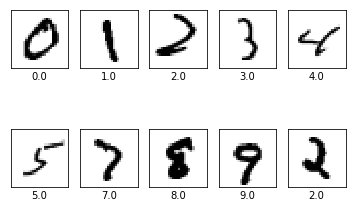

In [3]:
for i in range(10):
  plt.subplot(2,5,i+1)
  plt.imshow(data[i*7000].reshape(28,-1),cmap = matplotlib.cm.binary,
           interpolation="nearest")
  plt.xlabel(target[i*7000])
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])


### 創建Testing set

In [4]:
X_train, X_test, y_train, y_test = data[:60000], data[60000:], target[:60000], target[60000:]

### 打散數據

In [5]:
suffle_index = np.random.permutation(60000)
X_train, y_train = X_train[suffle_index], y_train[suffle_index]

### 分類器

In [6]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test==5)

y_train_5

array([ True, False,  True, ..., False, False, False])

In [7]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42, max_iter=5, tol=None)
sgd_clf.fit(X_train, y_train_5)

sgd_clf.predict([X_train[100]])

array([False])

### 交叉驗證

In [8]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy") # 3 個 fold

array([0.95795, 0.964  , 0.9673 ])

### 混淆矩陣

`cross_val_predict` 同樣進行交叉驗證，但返回的不是評估分數，每個實例的預測 (prediction)

In [9]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
print(y_train_pred)   
# 使用confusion_matrix 獲取混淆矩陣 (行 為 實際值， 列 為 預測值)
from sklearn.metrics import confusion_matrix

#            非5(pred)  是5(pred)
#  非5(real)   xxx      0(理想)     | 精
#  是5(real)   0(理想)  xxx         | 度
#              ---------------
#                召回率

# 召回率高,精度低 : 只要是五一定辨認得出來，但預測中帶有很多假正類(其他數字) 
# 召回率低,精度高 : 容易將五判斷為非五(其他數字)，但預測中帶有假正類的比率低(幾乎為五)

## ! 不能同時增加精度並減少召回率，反之亦然 (相同模型下)
cmt = confusion_matrix(y_train_5, y_train_pred)
cmt

[ True False  True ... False False False]


array([[53485,  1094],
       [ 1121,  4300]], dtype=int64)

In [10]:
# 精度 : 在預測之中，真正類占多少
print(cmt[1][1]/(cmt[1][1]+cmt[0][1]))
# 召回率 : 在所有該類中，找到幾個判斷為正類
print(cmt[1][1]/(cmt[1][1]+cmt[1][0]))

0.7971820541342232
0.7932115845784911


#### scikit 也有提供精度和召回率的函數

In [11]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.7971820541342232
0.7932115845784911


#### 精度和召回率可以組合成指標： F1 分數，可用來比較兩種分類器
只有當精度和召回率都很高，才會得到較高的F1分數

In [12]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7951918631530283

#### 閾值
調用分類器的`decision_function`，可以返回實例的預測分數

分類器判斷實例的分數，依據閾值(大於小於) 來分類 (**SGDClassifier使用的閾值為 0**)

In [13]:
y_score = sgd_clf.decision_function([X_train[150]])
y_score

array([-45133.43837359])

#### 使用 cross_val_predict 交叉驗證，並返回每個實例的決策分數而非預測結果

In [14]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
y_scores

array([  82514.8409573 , -471889.11130115,  187463.97005745, ...,
       -200118.29320536, -744528.31514576, -465426.6280727 ])

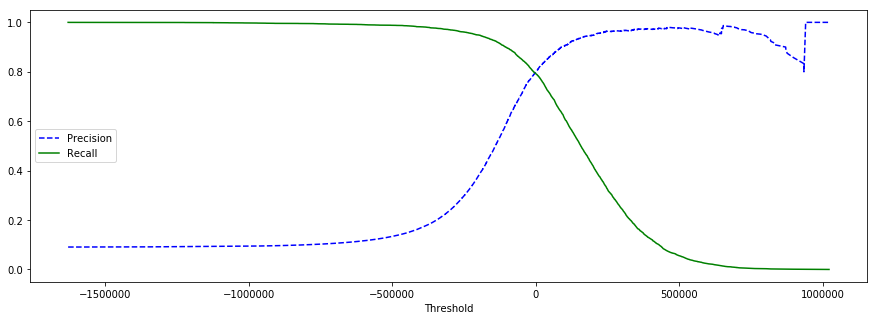

In [15]:
from sklearn.metrics import precision_recall_curve
precision, recalls, thresholds = precision_recall_curve(y_train_5, y_scores) # 利用不同 thresholds 預測
plt.figure(figsize=(15,5))
plt.plot(thresholds, precision[:-1],"b--", label="Precision")
plt.plot(thresholds, recalls[:-1],"g-", label="Recall")
plt.xlabel("Threshold")
plt.legend(loc="center left")
plt.show()

### PR曲線(精度/召回率)

希望曲線更接近右上角

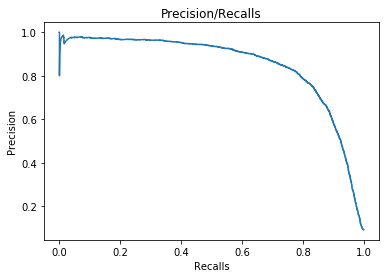

In [16]:
plt.plot(recalls[:-1],precision[:-1])
plt.title("Precision/Recalls")
plt.xlabel("Recalls")
plt.ylabel("Precision")
plt.show()

#### 假設瞄準約90%的精度 (約在 threshold = 70000 的位置)

In [17]:
y_train_pred_90 = (y_scores > 70000)
p_score = precision_score(y_train_5, y_train_pred_90)
r_score = recall_score(y_train_5, y_train_pred_90)
print("精度:{}\n召回率:{}".format(p_score,r_score))

精度:0.8815853069115515
召回率:0.6729385722191478


### receiver operating characteristic curve

和 精度/召回率 曲線非常相似，但我們這次繪製的是 召回率(真正類率)/假正類率(FPR)

展示召回率高，同時也造成假正類率上升

In [18]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

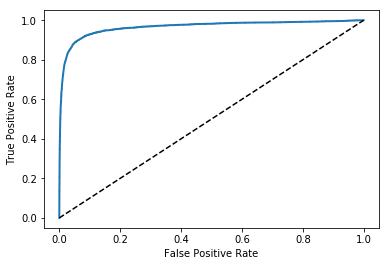

In [19]:
plt.plot(fpr, tpr,linewidth=2)
plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

### AUC

一種衡量分類器的方法，(曲線下面積)

完美的分類器的 ROC AUC 等於一 ( 一條tpr = 1 的直線 ?)

In [20]:
# Scikit learn 提供計算 ROC AUC 的方法
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9655515498133439

#### 使用ROC還是PR曲線?  P.91

ROC : 較關心召回率 (假負類) 可以判斷錯

PR : 較關心精度 (假正類) 可以沒判斷到，但不能錯

### 使用另一種分類器

RandomForestClassifier

In [21]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=10,random_state=42)
y_probas_forest = cross_val_predict(forest_clf,X_train,y_train_5,cv=3,
                                    method="predict_proba") # 算分數方式和SGD不同
#運作方式和SGDClassifier不同 , 返回該實例所有類別的可能性(此例中為正類、負類)
y_probas_forest

array([[0.5, 0.5],
       [0.8, 0.2],
       [0.5, 0.5],
       ...,
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ]])

In [22]:
# 直接使用正類概率作為分數
y_score_forest = y_probas_forest[:,1]

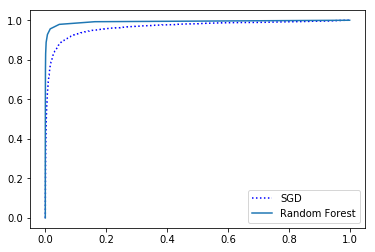

In [23]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_score_forest)
plt.plot(fpr, tpr, "b:", label="SGD")
plt.plot(fpr_forest, tpr_forest, label="Random Forest")
plt.legend(loc="lower right")
plt.show()

In [24]:
y_forest_predict = cross_val_predict(forest_clf,X_train,y_train_5,cv=3)
pre_forest, re_forest = precision_score(y_train_5,y_forest_predict), recall_score(y_train_5,y_forest_predict)
print("精度:{}\n召回率:{}".format(pre_forest,re_forest))

精度:0.9859894921190894
召回率:0.8308430178933776


#### 接著使用 y_train 而非 y_train_5 進行多類別訓練，Scikit learn會自動套用OvA (除了SVM會使用OvO) 來訓練

此例中 實際訓練了十個二元分類器(0~9)

In [25]:
print(y_train_5)
print(y_train)

[ True False  True ... False False False]
[5. 4. 5. ... 3. 8. 1.]


In [26]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([X_train[100]]) # 判斷從 True, False (正負類) 變成數字 (判斷為哪個數字/類別)

array([4.])

In [27]:
# 返回十個分數
some_digit_score = sgd_clf.decision_function([X_train[100]])
some_digit_score

array([[-612915.90227024, -628384.17044624, -297166.75727085,
        -154661.58484408,  290687.68930998, -299137.23905066,
        -333434.28386654, -257596.06683518, -122472.63993126,
        -441220.73625797]])

#### 可使用 OneVsRestClassifier/OneVsOneClassifier 來限制使用 OvA/ OvO

In [28]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42,max_iter=1000))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([X_train[100]])

array([4.])

#### 隨機森林分類器 多類別

隨機森林分類器直接就可以將實例分為多個類別，無須再運行OvO,OvA

In [29]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([X_train[100]])

array([4.])

#### 交叉驗證 SGD

In [30]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.86902619, 0.87489374, 0.86387958])

#### 標準化
可增加準確率

In [31]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scale, y_train, cv=3, scoring="accuracy")

array([0.90861828, 0.90834542, 0.91083663])

In [32]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scale, y_train, cv=3)
y_train_pred

array([5., 4., 5., ..., 3., 8., 1.])

In [33]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5742,    3,   22,   12,   11,   40,   43,    9,   35,    6],
       [   1, 6483,   44,   28,    5,   40,    7,   12,  112,   10],
       [  53,   42, 5320,  103,   81,   27,   88,   60,  169,   15],
       [  53,   42,  140, 5327,    3,  242,   34,   54,  140,   96],
       [  22,   27,   37,    9, 5358,   10,   44,   27,   88,  220],
       [  79,   37,   38,  177,   76, 4586,  113,   28,  188,   99],
       [  40,   23,   51,    2,   45,   88, 5613,    8,   46,    2],
       [  28,   19,   66,   28,   52,    7,    3, 5803,   13,  246],
       [  53,  160,   74,  150,   14,  150,   56,   34, 5012,  148],
       [  41,   33,   26,   88,  151,   31,    3,  186,   78, 5312]],
      dtype=int64)

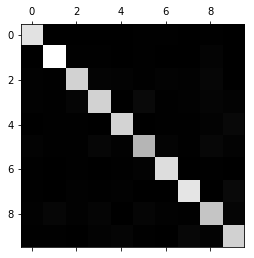

In [34]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()
# 正確預測的數量

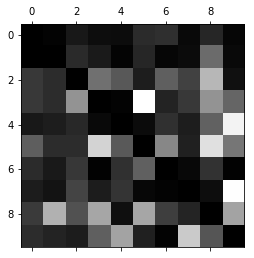

In [35]:
row_sums = conf_mx.sum(axis=1, keepdims=True) # 每類數量
norm_conf_mx = conf_mx/row_sums
# 用0填充對角線 
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()
# 預測錯誤的數量

In [36]:
def plot_digits(x,images_per_row, name=""):
    image = x.reshape(-1,28,28)
    image = np.array(image)
    row_images = []
    for row in range(images_per_row):
        r_image = image[row*images_per_row:(row+1)*images_per_row]
        row_images.append(np.concatenate(r_image, axis=1)) 
    image = np.concatenate(row_images, axis=0)
    plt.axis("off")
    plt.title(name)
    plt.imshow(image, cmap=plt.cm.binary)
    #plt.axis("off")
# def plot_digits(instances, images_per_row=10, **options):
#     size = 28
#     images_per_row = min(len(instances), images_per_row)
#     images = [instance.reshape(size,size) for instance in instances]
#     n_rows = (len(instances) - 1) // images_per_row + 1
#     row_images = []
#     n_empty = n_rows * images_per_row - len(instances)
#     images.append(np.zeros((size, size * n_empty)))
#     for row in range(n_rows):
#         rimages = images[row * images_per_row : (row + 1) * images_per_row]
#         row_images.append(np.concatenate(rimages, axis=1))
#     image = np.concatenate(row_images, axis=0)
#     print(image.shape)
#     plt.imshow(image, cmap = matplotlib.cm.binary, **options)
#     plt.axis("off")


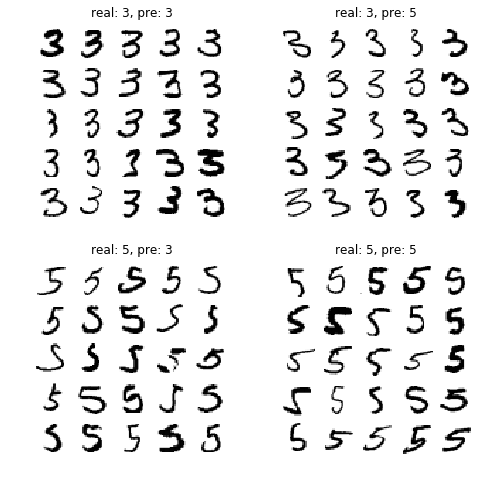

In [37]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train== cl_a) & (y_train_pred==cl_a)]
X_ab = X_train[(y_train== cl_a) & (y_train_pred==cl_b)]
X_ba = X_train[(y_train== cl_b) & (y_train_pred==cl_a)]
X_bb = X_train[(y_train== cl_b) & (y_train_pred==cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(2,2,1,); plot_digits(X_aa[:25], images_per_row=5,name="real: {}, pre: {}".format(cl_a,cl_a))
plt.subplot(2,2,2); plot_digits(X_ab[:25], images_per_row=5,name="real: {}, pre: {}".format(cl_a,cl_b))

plt.subplot(2,2,3); plot_digits(X_ba[:25], images_per_row=5,name="real: {}, pre: {}".format(cl_b,cl_a))
plt.subplot(2,2,4); plot_digits(X_bb[:25], images_per_row=5,name="real: {}, pre: {}".format(cl_b,cl_b))
plt.show()

### 多標籤分類

每個實例產出多個類

In [39]:
from sklearn.neighbors import KNeighborsClassifier # 支持多標籤分類，不是每個分類器都支持

y_train_larger = (y_train >= 7)
y_train_odd = (y_train%2==1)
y_multilabel = np.c_[y_train_larger, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train,y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

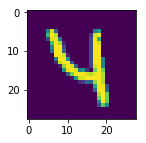

In [40]:
plt.figure(figsize=(2,2))
plt.imshow(X_train[100].reshape(28,-1))
pred = knn_clf.predict([X_train[100]])

In [41]:
print("大於等於七: ", pred[0][0])
print("奇數: ", pred[0][1])

大於等於七:  False
奇數:  False


In [42]:
# 這段會跑很久所以先註解掉： 這是交叉驗證並算 f1 分數
# y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
# f1_score(y_multilabel, y_train_knn_pred, average="macro")

### 多輸出分類

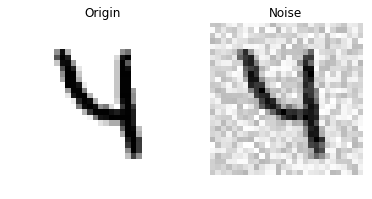

In [50]:
from numpy import random as rnd
noise_train = rnd.randint(0, 100, ((len(X_train),784)))
noise_test = rnd.randint(0,100,(len(X_test),784))
X_train_mod = X_train + noise_train
X_test_mod = X_test + noise_test
plt.subplot(1,2,1)
plot_digits(X_train[100].reshape(-1,784), images_per_row=1,name="Origin")
plt.subplot(1,2,2)
plot_digits(X_train_mod[100].reshape(-1,784), images_per_row=1,name="Noise")
plt.show()

In [52]:
knn_clf.fit(X_train_mod, X_train)
clean_digit = knn_clf.predict([X_test_mod[100]])

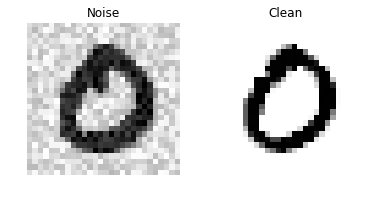

In [53]:
plt.subplot(1,2,1)
plot_digits(X_test_mod[100].reshape(-1,784), images_per_row=1,name="Noise")
plt.subplot(1,2,2)
plot_digits(clean_digit.reshape(-1,784), images_per_row=1,name="Clean")
plt.show()